# CDS 303 Group 3 Project: Phishing and Spam Categorization Code
### Outline of Code
- Importing the Cleaned Data With Unique Features
- Logistic Regression
- Exploration of Alternative Models
- Importing Tokenized and Vectorized Emails
- Apply the same models

## Importing the Cleaned Data

In [2]:
# Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

from sklearn import datasets, model_selection, metrics
from sklearn import linear_model, naive_bayes, tree
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Importing Data
df = pd.read_csv(r"./CSV Files/Post_EDA_encoded_df.csv")
df.head()

from sklearn.preprocessing import StandardScaler

# Scale the data
y = df['Safe_Email']
X = df.drop(['Safe_Email'], axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [3]:
# Splitting the Data, Training versus Testing
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_scaled, y, test_size=0.3)

X_train_pct = round((len(X_train) / (len(X_train) + len(X_test))), 2)
X_test_pct = round((len(X_test) / (len(X_train) + len(X_test))), 2)

print('Classification training dataset shape is:', X_train.shape, 'Testing dataset shape is:', X_test.shape)
print('Regression train/test split is:', X_train_pct, '/', X_test_pct)

Classification training dataset shape is: (12670, 19) Testing dataset shape is: (5431, 19)
Regression train/test split is: 0.7 / 0.3


## Logistic Regression
### Creation and Tuning

In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

In [5]:
# Define your logistic regression model
logistic_model = linear_model.LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

# Stratified K-Fold cross-validation
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds)

# Initialize lists to store evaluation metrics for each fold
fold_results = []

for fold_idx, (train_index, val_index) in enumerate(skf.split(X_train, y_train), 1):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    
    # Train the model on the training fold
    logistic_model.fit(X_train_fold, y_train_fold)
    
    # Make predictions on the validation fold
    y_pred_fold = logistic_model.predict(X_val_fold)
    
    # Evaluate the model on the validation fold
    accuracy = accuracy_score(y_val_fold, y_pred_fold)
    precision = precision_score(y_val_fold, y_pred_fold)
    recall = recall_score(y_val_fold, y_pred_fold)
    f1 = f1_score(y_val_fold, y_pred_fold)
    
    # Store the results for this fold
    fold_results.append({'Fold': fold_idx,
                         'Accuracy': accuracy,
                         'Precision': precision,
                         'Recall': recall,
                         'F1 Score': f1})

# Create a DataFrame to store the fold-wise results
results_df = pd.DataFrame(fold_results)

# Calculate mean scores across all folds
mean_scores = results_df.mean(axis=0)

# Create a DataFrame for mean scores
mean_scores_df = pd.DataFrame(mean_scores).transpose()

# Set the 'Fold' column to 'Mean' for the mean scores DataFrame
mean_scores_df['Fold'] = 'Mean'

# Concatenate the mean scores DataFrame with the original results DataFrame
results_df = pd.concat([results_df, mean_scores_df], ignore_index=True)

# Display the results DataFrame
results_df

,Fold,Accuracy,Precision,Recall,F1 Score
0,1,0.759669,0.732840,0.956186,0.829746
1,2,0.751776,0.728218,0.948420,0.823859
2,3,0.754144,0.732932,0.941328,0.824160
3,4,0.741910,0.722360,0.939394,0.816704
4,5,0.764009,0.738131,0.952289,0.831644
5,Mean,0.754301,0.730896,0.947523,0.825223


We fit the model, but we have unbalanced classes. Because there are approximately 11,000 safe emails versus 7,000 unsafe emails, we use stratified k-fold cross validation.

The model has a mean accuracy of .75 across all 5 of the folds. This is the overall correctness of the model. It is measured by taking the overall correct predictions divided by the total number of cases examined. Precision refers to the accuracy of the positive predictions. Recall is important when the cost of a false negative is high because it is a measure of the actual positives identified by the model. Finally, the F-Score capture the precision and recall in one number.

- Accuracy= TP+TN+FP+FN / TP+TN

- Precision= TP / TP+FP

- Recall= TP / TP+FN

- F1 Score= 2 x (Precision x Recall) / (Precision + Recall)

This Accuracy score seems quite low for the use case. We would like to predict the type of emails at least 95% of the time. The following section we explore the hyperparameter space for Logarithmic Regression.

#### Hyperparameter Search
There are 5 different hyperparameters for the logistic regression model. We perform a grid search to find the best hyperparameter. We will use the F1 score as our primary consideration for comparing the models with different hyperparameters because we have imbalanced classes and want to account for both the perfomance of the model on precision and recall.

One significant Hyperparameter is the C (Inverse Regularization Strength). This is used to prevent overfitting. A high value of C means there is less regularization and the risk of overfitting. A low vaule means there is a risk of underfitting.

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np

import warnings
warnings.filterwarnings("ignore")
from sklearn.exceptions import FitFailedWarning

In [6]:
# Ignore FitFailedWarning, because some of the combinations of hyperparameters are expected to not converge
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FitFailedWarning)

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Logistic Regression model
model = LogisticRegression(max_iter=1000)  # Increased max_iter for convergence

# Grid of parameters to search over
param_grid = [
    {'penalty': ['l1', 'l2'], 'solver': ['liblinear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'penalty': ['l2', 'none'], 'solver': ['newton-cg', 'lbfgs', 'sag'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'penalty': ['elasticnet'], 'solver': ['saga'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'l1_ratio': np.linspace(0, 1, 10)}
]

# GridSearchCV to find the best parameters, score on f1 to balance the consideration of performance on recall and precision
clf = GridSearchCV(model, param_grid, cv=5, scoring='f1')
clf.fit(X_train, y_train)

# Output the best parameters and best score
print("Best parameters:", clf.best_params_)
print("Best cross-validation score: {:.2f}".format(clf.best_score_))


Best parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation score: 0.83


Output:
Best parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation score: 0.83
These hyperparameters are added to the original code for logarithmic regression.

### Testing and Interpretation of Results

Here we define a function to create a correlation matrix. The benefit of using a function is that we can use it to compare to other modeling approaches, which we will in the next section.

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [8]:
def plot_confusion_matrix_for_model(model, X_train, X_test, y_train, y_test, model_name, ax=None):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    if ax is None:
        plt.figure(figsize=(4, 3))
        ax = plt.gca()
    
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', 
                xticklabels=['Predicted Unsafe', 'Predicted Safe'], 
                yticklabels=['Actual Unsafe', 'Actual Safe'], ax=ax)
    ax.set_title(f'Confusion Matrix for {model_name}')
    ax.set_ylabel('Actual label')
    ax.set_xlabel('Predicted label')

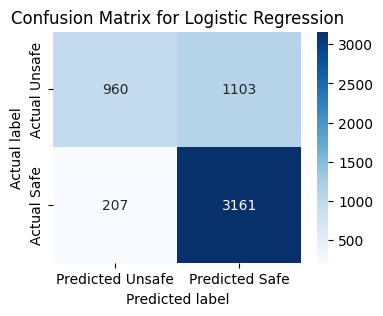

In [9]:
plot_confusion_matrix_for_model(logistic_model, X_train, X_test, y_train, y_test, "Logistic Regression")


The results are somewhat of a summary of the same information encapsulated in the Accuracy Score and F Score. We can see that the model is more likely to accidently predict something as safe when it is actually unsafe when compared to accidently predicting something as unsafe when it is safe. Or p(FP) > p(FN)

## Comparison to Other Models
The following code runs through several alternative models including: K Nearest Neighbors, Support Vector Machine, Decision Tree Classifier, Random Forest Classifier, and Multi Layer Perceptron Classifier.

- *K Nearest Neighbor* or KNN categorize points by the category of whichever group has the most points near it given some number of nearest points. This is considered a "lazy learner."
- *Support Vector Machine* can be used for classification or regression. It searches for a "hyperplane" that best seperates the classes in a high-dimensional space.
- *Decision Tree Clssifier* constructs decision trees dividing data based on the feature that will give the largest information gain on each level of analysis.
- *Random Forest Classifier* outputs the mean prediction of a forest of decision trees from training.
- *Multi Layer Perceptron Classifier* is an artificial neural network where every node is fully connected to the nodes in adjacent layers.

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import itertools
import pandas as pd

In [11]:
param_dict = {
    'knn': ('n_neighbors', [2, 3, 4, 5, 6, 7, 8], 'weights', ['uniform', 'distance']),
    'svc': ('C', [1, 2], 'kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
    'dt': ('criterion', ['gini', 'entropy', 'log_loss'], 'max_depth', [2, 3, 4, 5, 6]),
    'rf': ('n_estimators', [50, 100, 150, 200], 'max_depth', [2, 3, 4, 5, 6]),
    'mlp': ('activation', ['identity', 'logistic', 'tanh', 'relu'], 'solver', ['lbfgs', 'sgd', 'adam'])
}

model_dict = {
    'knn': KNeighborsClassifier(),
    'svc': SVC(),
    'dt': DecisionTreeClassifier(),
    'rf': RandomForestClassifier(),
    'mlp': MLPClassifier(),
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

summary = []
cm_df = pd.DataFrame()

for i in ['knn', 'svc', 'dt', 'rf', 'mlp']:
    param_grid = list(itertools.product(param_dict[i][1], param_dict[i][3]))
    for k in range(len(param_grid)):
        param_grid_dict = {param_dict[i][0]: param_grid[k][0], param_dict[i][2]: param_grid[k][1]}
        model = model_dict[i]
        
        for train_index, test_index in skf.split(X_scaled, y):
            X_train, X_test = X_scaled[train_index], X_scaled[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            model.set_params(**param_grid_dict)
            clf = model.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            
            summary.append([i, param_dict[i][0], param_grid[k][0], param_dict[i][2], param_grid[k][1],
                            accuracy_score(y_test, y_pred), precision_score(y_test, y_pred, average='macro'),
                            recall_score(y_test, y_pred, average='macro'), f1_score(y_test, y_pred, average='macro')])
            
            dfpred = pd.DataFrame([y_pred]).transpose()
            dftest = pd.DataFrame([y_test]).transpose()
            cm_data_temp = pd.concat([dfpred, dftest], axis=1)
            cm_df = pd.concat([cm_df, cm_data_temp], axis=0)

summary_df = pd.DataFrame(summary, columns=('model', 'param1', 'parval1', 'param2', 'parval2', 'accuracy', 'precision', 'recall', 'f1'))
best_df = summary_df.nlargest(15, 'f1')
cm_df.columns = ('ypred', 'ytest')

best_df

,model,param1,parval1,param2,parval2,accuracy,precision,recall,f1
331,mlp,activation,relu,solver,lbfgs,0.851105,0.846691,0.835957,0.840511
45,knn,n_neighbors,6,weights,distance,0.848937,0.843065,0.835577,0.838896
316,mlp,activation,tanh,solver,lbfgs,0.849448,0.844986,0.834074,0.838686
46,knn,n_neighbors,6,weights,distance,0.846961,0.840869,0.833523,0.836783
319,mlp,activation,tanh,solver,lbfgs,0.846133,0.838793,0.834905,0.836724
55,knn,n_neighbors,7,weights,distance,0.847004,0.841365,0.832936,0.836617
68,knn,n_neighbors,8,weights,distance,0.846961,0.841749,0.832186,0.836296
35,knn,n_neighbors,5,weights,distance,0.845899,0.839426,0.832971,0.835872
58,knn,n_neighbors,7,weights,distance,0.846133,0.840711,0.831511,0.835484
69,knn,n_neighbors,8,weights,distance,0.846409,0.842164,0.830329,0.835253


The best results across these models are comparable to the Logistic Regression result.
Below are the correlation matrices for the 2 best models: mlp, knn.

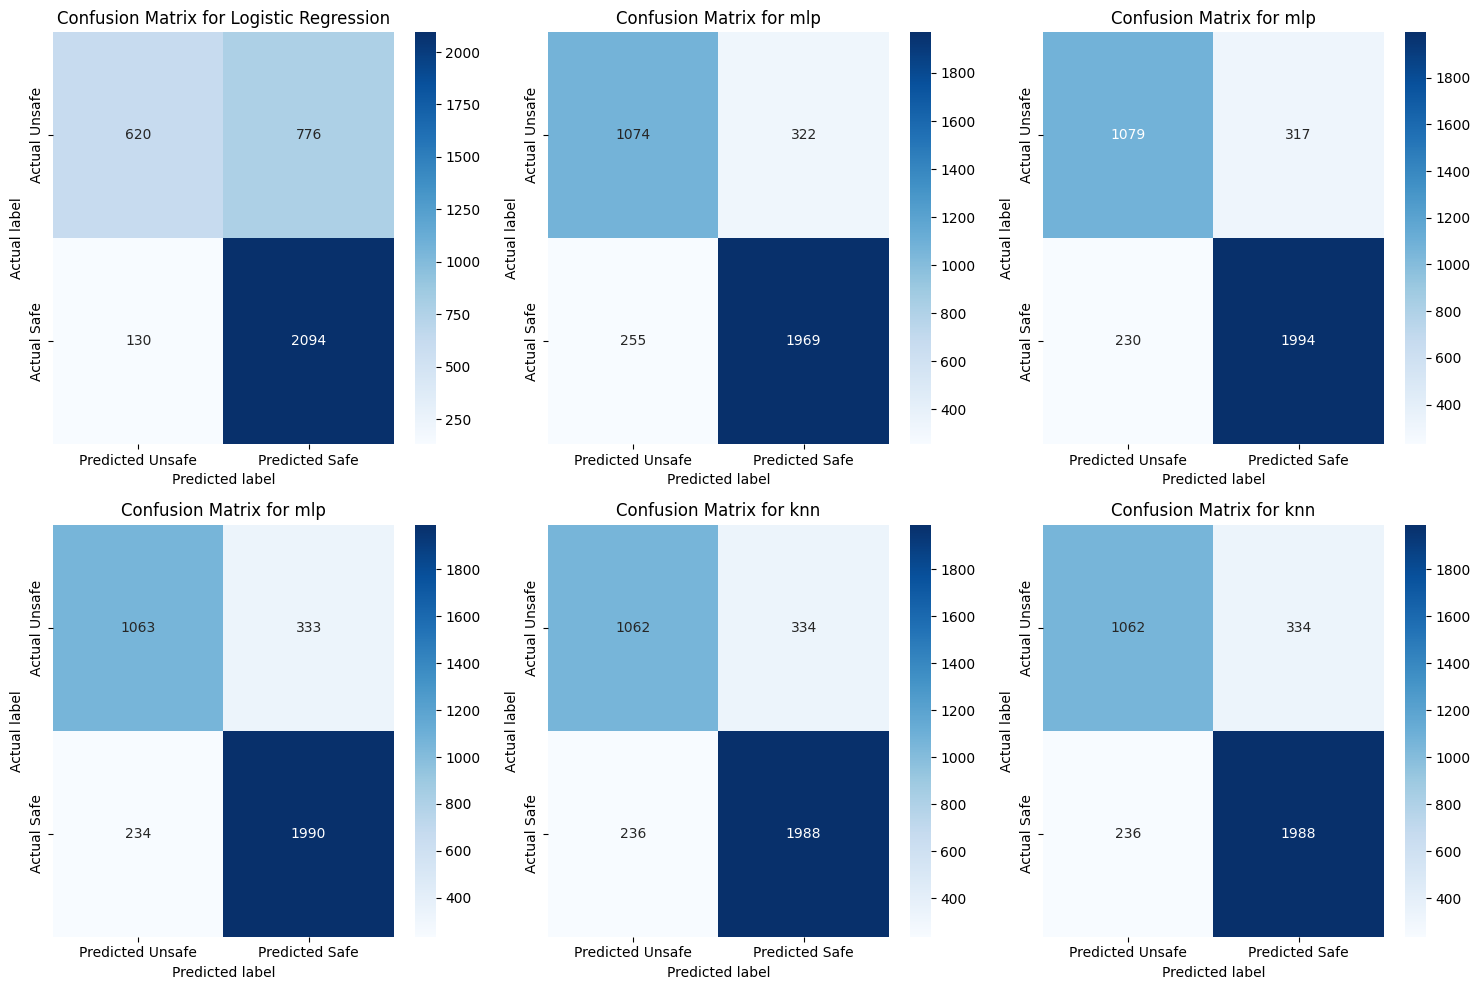

In [12]:
# Sort best_df by F1 score in descending order and select the top 5 models
top_5_models_df = best_df.nlargest(5, 'f1')

# Extract Hyperparameters for Top 5 Models
best_hyperparameters_top_5 = top_5_models_df[['model', 'param1', 'parval1', 'param2', 'parval2']].values

# Reinitialize Models with Hyperparameters
models_with_hyperparameters_top_5 = {}
for row in best_hyperparameters_top_5:
    model_name, param1, parval1, param2, parval2 = row
    if model_name in model_dict:
        model = model_dict[model_name]
        model.set_params(**{param1: parval1, param2: parval2})
        if model_name not in models_with_hyperparameters_top_5:
            models_with_hyperparameters_top_5[model_name] = []
        models_with_hyperparameters_top_5[model_name].append(model)

# Fit Models with Training Data
trained_models_top_5 = {}
for model_name, models_list in models_with_hyperparameters_top_5.items():
    trained_models_top_5[model_name] = []
    for model in models_list:
        clf = model.fit(X_train, y_train)
        trained_models_top_5[model_name].append(clf)


# Plotting all confusion matrices in a grid
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Plot Logistic Regression Confusion Matrix
plot_confusion_matrix_for_model(logistic_model, X_train, X_test, y_train, y_test, "Logistic Regression", ax=axs[0, 0])
axs[0, 0].set_title("Confusion Matrix for Logistic Regression")

# Plotting other confusion matrices
row = 0
col = 1
for model_name, model_list in trained_models_top_5.items():
    for model in model_list:
        plot_confusion_matrix_for_model(model, X_train, X_test, y_train, y_test, model_name, ax=axs[row, col])
        axs[row, col].set_title(f"Confusion Matrix for {model_name}")
        col += 1
        if col == 3:
            col = 0
            row += 1

plt.tight_layout()
plt.show()


The results make clear that the mlp models outperform the logistic regression approach by having fewer unsafe emails predicted as safe. Our best approach still only get us to an accuracy in the 80s. That means that we could be getting roughly 1 in 5 predictions wrong. It is clear that our first approach is not working. We are losing a lot of the potential information by hand selecting certain features from the text data. The following approach captures more information and has better results.

## Logistic Regression on Vectorized Email Text Data
### The Process
In order to capture more of the information from the email text data we need to tokenize and vectorize the email text data. As opposed to looking for specific features, this approach cuts each word in the email text down to its root, each of these being a "token." These tokens are then assigned numerical values, so the text is now represented as vectors. We defined the following function below and used it in an EDA notebook and exported the transformed data to a csv file for repeated access to the tokenized data.

In [11]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [14]:
# Preprocessing and tokenization function
def preprocess_and_tokenize(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove stopwords and lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    return tokens

It is then an easy process to vectorize the data.

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [19]:
# Load the data
df = pd.read_csv(r"./CSV Files/Sentiment_Analysis_Export_df.csv")

# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fitting the vectorizer to the text
tfidf_vectorizer.fit(df["Tokenized_Text"])

# Transforming tokenized text into TF-IDF vectors
tfidf_vectors = tfidf_vectorizer.transform(df["Tokenized_Text"])

### Training
To train the model we will run the same models as we did on the previous data approach, but we run two blocks of models because this is easier to run and debug.

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

# Importing df if not already
df = pd.read_csv(r"./CSV Files/Post_EDA_encoded_df.csv")
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(tfidf_vectors, df["Safe_Email"], test_size=0.3, random_state=42)

# Define your models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC()
}

# Stratified K-Fold cross-validation
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds)

# Initialize lists to store evaluation metrics for each model
model_results = []

for model_name, model in models.items():
    fold_results = []
    for fold_idx, (train_index, val_index) in enumerate(skf.split(X_train, y_train), 1):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        # Train the model on the training fold
        model.fit(X_train_fold, y_train_fold)

        # Make predictions on the validation fold
        y_pred_fold = model.predict(X_val_fold)

        # Evaluate the model on the validation fold
        accuracy = accuracy_score(y_val_fold, y_pred_fold)
        precision = precision_score(y_val_fold, y_pred_fold)
        recall = recall_score(y_val_fold, y_pred_fold)
        f1 = f1_score(y_val_fold, y_pred_fold)

        # Store the results for this fold
        fold_results.append({'Fold': fold_idx,
                             'Accuracy': accuracy,
                             'Precision': precision,
                             'Recall': recall,
                             'F1 Score': f1})

    # Create a DataFrame to store the fold-wise results
    fold_results_df = pd.DataFrame(fold_results)

    # Calculate mean scores across all folds
    mean_scores = fold_results_df.mean(axis=0)

    # Create a DataFrame for mean scores
    mean_scores_df = pd.DataFrame(mean_scores).transpose()

    # Set the 'Fold' column to 'Mean' for the mean scores DataFrame
    mean_scores_df['Fold'] = 'Mean'

    # Concatenate the mean scores DataFrame with the original results DataFrame
    fold_results_df = pd.concat([fold_results_df, mean_scores_df], ignore_index=True)

    # Append the results to the model_results list
    model_results.append({'Model': model_name, 'Results': fold_results_df})

# Display the results
for result in model_results:
    print(result['Model'])
    print(result['Results'])


Logistic Regression
   Fold  Accuracy  Precision    Recall  F1 Score
0     1  0.973560   0.969562  0.987726  0.978560
1     2  0.977506   0.974539  0.989018  0.981725
2     3  0.968824   0.962240  0.987726  0.974817
3     4  0.974349   0.971392  0.987080  0.979173
4     5  0.970008   0.965234  0.986434  0.975719
5  Mean  0.972849   0.968593  0.987597  0.977999
Random Forest
   Fold  Accuracy  Precision    Recall  F1 Score
0     1  0.979874   0.981970  0.985142  0.983554
1     2  0.980663   0.980757  0.987726  0.984229
2     3  0.969219   0.974806  0.974806  0.974806
3     4  0.971981   0.975531  0.978682  0.977104
4     5  0.966851   0.972258  0.973514  0.972886
5  Mean  0.973717   0.977065  0.979974  0.978516
SVM
   Fold  Accuracy  Precision    Recall  F1 Score
0     1  0.983031   0.983301  0.989018  0.986151
1     2  0.983031   0.980831  0.991602  0.986187
2     3  0.978295   0.977607  0.987080  0.982321
3     4  0.981847   0.982028  0.988372  0.985190
4     5  0.979874   0.978275  0

### Summary of Results
This approach already allows for a much closer fit using the Logistic Regression model. It has an accuracy score in the high 90s.There is still a skew in the Logistic Regression towards predicting some phishing emails as safe, but since this method is computationally efficient with little difference in results, this is are choice of model.

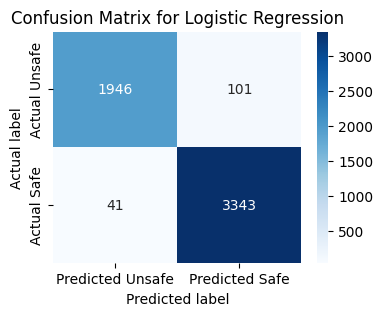

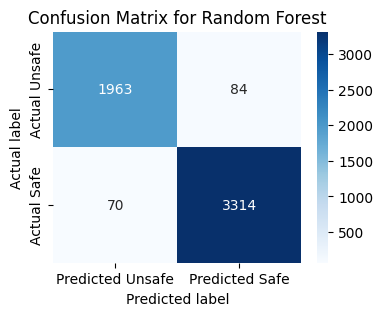

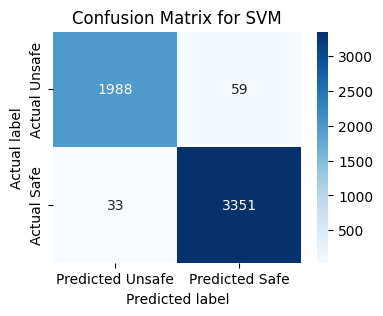

In [21]:
# Plotting confusion matrices for each model
for result in model_results:
    model_name = result['Model']
    model = models[model_name]
    plot_confusion_matrix_for_model(model, X_train, X_test, y_train, y_test, model_name)
    plt.show()


### More Models

MLP is an effective model, but it is computationally intense, making it a less desirable choice for a binary classification problem of our nature.

In [22]:
# Define your models
models = {
    'KNN': KNeighborsClassifier(),
    'mlp_model': MLPClassifier(),
    'RF' : RandomForestClassifier()
}

# Stratified K-Fold cross-validation
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds)

# Initialize lists to store evaluation metrics for each model
model_results2 = []

for model_name, model in models.items():
    fold_results = []
    for fold_idx, (train_index, val_index) in enumerate(skf.split(X_train, y_train), 1):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        # Train the model on the training fold
        model.fit(X_train_fold, y_train_fold)

        # Make predictions on the validation fold
        y_pred_fold = model.predict(X_val_fold)

        # Evaluate the model on the validation fold
        accuracy = accuracy_score(y_val_fold, y_pred_fold)
        precision = precision_score(y_val_fold, y_pred_fold)
        recall = recall_score(y_val_fold, y_pred_fold)
        f1 = f1_score(y_val_fold, y_pred_fold)

        # Store the results for this fold
        fold_results.append([fold_idx, accuracy, precision, recall, f1])

    # Create a DataFrame to store the fold-wise results
    fold_results_df = pd.DataFrame(fold_results, columns = ["Fold", "Accuracy", "Precision", "Recall", "F1 Score"])

    # Calculate mean scores across all folds
    mean_scores_df = pd.DataFrame(fold_results_df.mean(axis=0)).transpose()

    # Set the 'Fold' column to 'Mean' for the mean scores DataFrame
    mean_scores_df['Fold'] = 'Mean'

    # Concatenate the mean scores DataFrame with the original results DataFrame
    fold_results_df = pd.concat([fold_results_df, mean_scores_df], ignore_index=True)

    # Append the results to the model_results list
    model_results2.append({'Model': model_name, 'Results': fold_results_df})

# Display the results
for result in model_results2:
    print(result['Model'])
    print(result['Results'])


KNN
   Fold  Accuracy  Precision    Recall  F1 Score
0     1  0.947908   0.962141  0.952196  0.957143
1     2  0.951855   0.972185  0.948320  0.960105
2     3  0.942384   0.971736  0.932817  0.951879
3     4  0.944357   0.976303  0.931525  0.953388
4     5  0.936859   0.961436  0.934109  0.947575
5  Mean  0.944672   0.968760  0.939793  0.954018
mlp_model
   Fold  Accuracy  Precision    Recall  F1 Score
0     1  0.982636   0.983290  0.988372  0.985825
1     2  0.988556   0.989053  0.992248  0.990648
2     3  0.983820   0.987702  0.985788  0.986744
3     4  0.986188   0.987122  0.990310  0.988713
4     5  0.985793   0.987113  0.989664  0.988387
5  Mean  0.985399   0.986856  0.989276  0.988064
RF
   Fold  Accuracy  Precision    Recall  F1 Score
0     1  0.980268   0.980745  0.987080  0.983902
1     2  0.976717   0.978163  0.983850  0.980998
2     3  0.965667   0.972816  0.970930  0.971872
3     4  0.977506   0.980658  0.982558  0.981607
4     5  0.976717   0.979395  0.982558  0.980974
5  

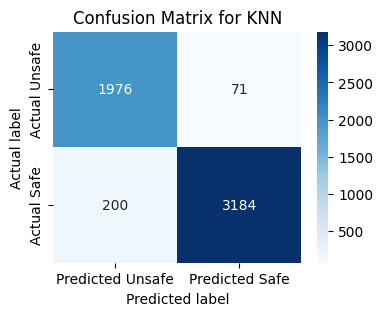

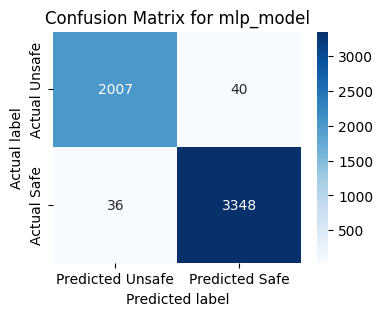

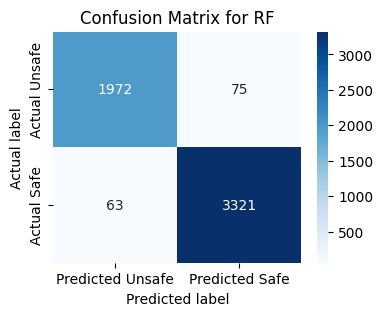

In [23]:
# Plotting confusion matrices for each model
for result in model_results2:
    model_name = result['Model']
    model = models[model_name]
    plot_confusion_matrix_for_model(model, X_train, X_test, y_train, y_test, model_name)
    plt.show()